In [23]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import mapping
from rasterio.mask import mask
from shapely.geometry import box
from IPython.display import display
from matplotlib import pyplot as plt



In [40]:
'''
Essentially this is a function that takes an array of rasterFiles and the zip intervals of the given state.
The function simply splices the shape file to only show the given zip intervals.
It then takes the average of the raster_files given for each zip interval to then display it.
I downloaded the raster files for monthly mean temperatures so I simply call the function with the given
months to find the average temperatures for those months then add them over the shape file. The function also
takes in title and the other necessary parameters for the visualization. As a result, I simply change which
raster files I am calling to change the season or change the zip intervals to change the state.
There is currently an issue with Texas zip codes and I will look more into it.
'''
def plot_seasonal_temperature(raster_files,
                              zip_intervals,
                              shapefile_path,
                              title="Seasonal Mean Temperature",
                              cmap="coolwarm",
                              figsize=(10, 10),
                              vmin=None,
                              vmax=None):

    zip_gdf = gpd.read_file(shapefile_path)

    def zip_in_intervals(zip_val, intervals):
        try:
            z = int(zip_val)
            return any(low <= z <= high for (low, high) in intervals)
        except (ValueError, TypeError):
            return False

    filtered_gdf = zip_gdf[zip_gdf["ZCTA5CE20"].apply(lambda z: zip_in_intervals(z, zip_intervals))].copy()

    with rasterio.open(raster_files[0]) as src_ref:
        raster_crs = src_ref.crs

    if filtered_gdf.crs != raster_crs:
        filtered_gdf = filtered_gdf.to_crs(raster_crs)

    seasonal_mean_temps = []

    for idx, row in filtered_gdf.iterrows():
        geom = row['geometry']
        monthly_means = []

        for raster_file in raster_files:
            with rasterio.open(raster_file) as src:
                try:
                    out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                    data = out_image.reshape(out_image.shape[0], -1)

                    if src.nodata is not None:
                        data = np.where(data == src.nodata, np.nan, data)

                    valid_pixels = np.count_nonzero(~np.isnan(data))
                    if valid_pixels > 0:
                        month_mean = np.nanmean(data)
                        monthly_means.append(month_mean)
                    else:
                        monthly_means.append(np.nan)
                except Exception as e:
                    print(f"Error processing polygon index {idx} in file {raster_file}: {e}")
                    monthly_means.append(np.nan)

        if monthly_means and np.count_nonzero(~np.isnan(monthly_means)) > 0:
            seasonal_mean = np.nanmean(monthly_means)
        else:
            seasonal_mean = np.nan
        seasonal_mean_temps.append(seasonal_mean)

    filtered_gdf['seasonal_mean_temp'] = seasonal_mean_temps


    ax = filtered_gdf.plot(column='seasonal_mean_temp', cmap=cmap, legend=True, figsize=figsize, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

    return filtered_gdf


In [37]:
meanTemp_DJF = [
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202301_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202302_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202312_bil.bil",
]
meanTemp_MAM = [
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202303_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202304_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202305_bil.bil",
]
meanTemp_JJA = [
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202306_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202307_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202308_bil.bil",
]
meanTemp_SON = [
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202309_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202310_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202311_bil.bil",
]
georgia_intervals = [(30000, 31999), (39800, 39999)]
texasIntervals = [(73300, 73399), (75000, 77099), (77200, 79999), (88510, 88589)]


shapefile_path = "/Users/Rk/Downloads/School/GROWER/SpringTask2/nhgis0002_shape/nhgis0002_shapefile_tl2023_us_zcta_2023/US_zcta_2023.shp"


Number of ZIP-code polygons after filtering: 751


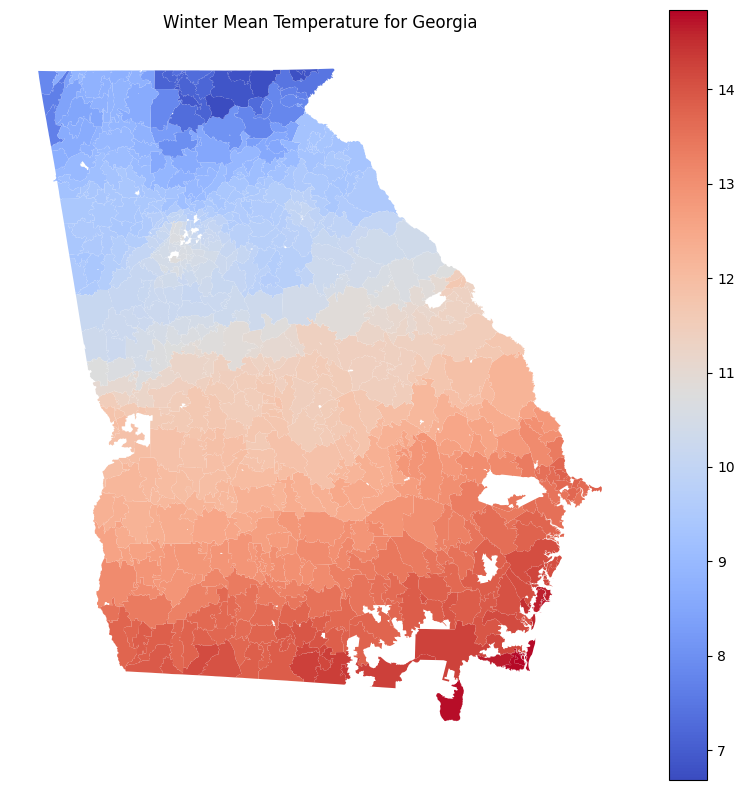

Number of ZIP-code polygons after filtering: 751


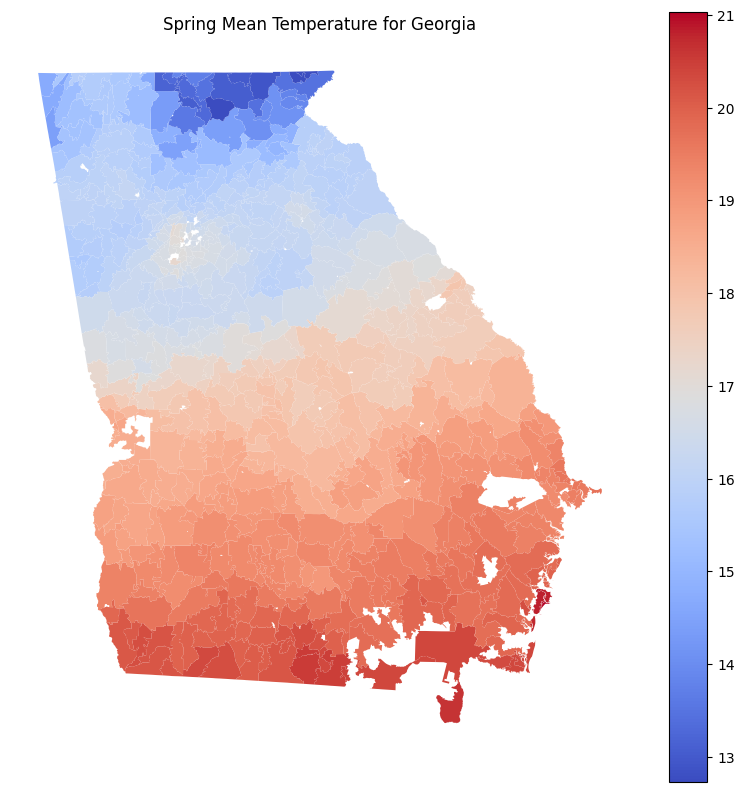

Number of ZIP-code polygons after filtering: 751


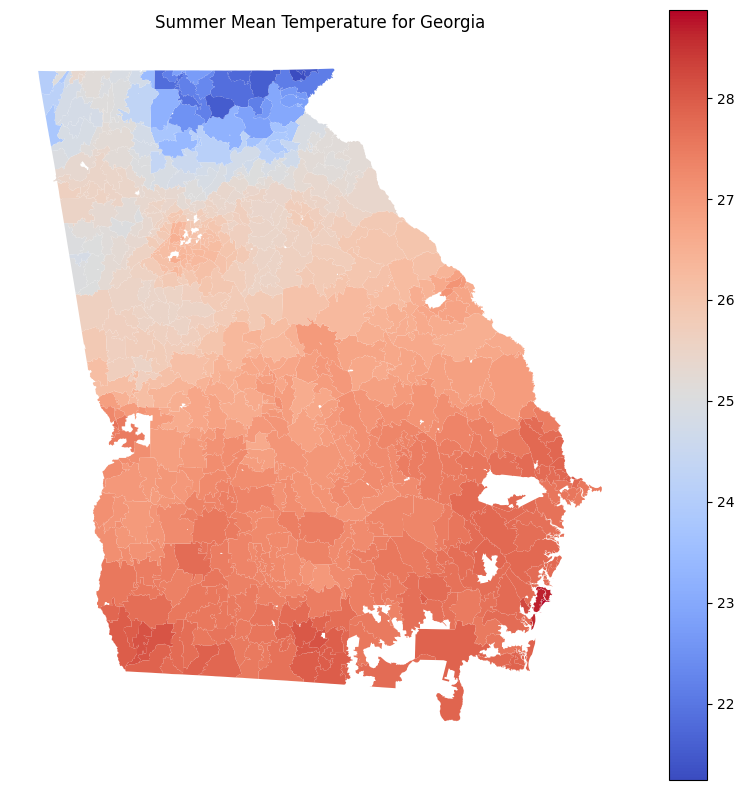

Number of ZIP-code polygons after filtering: 751


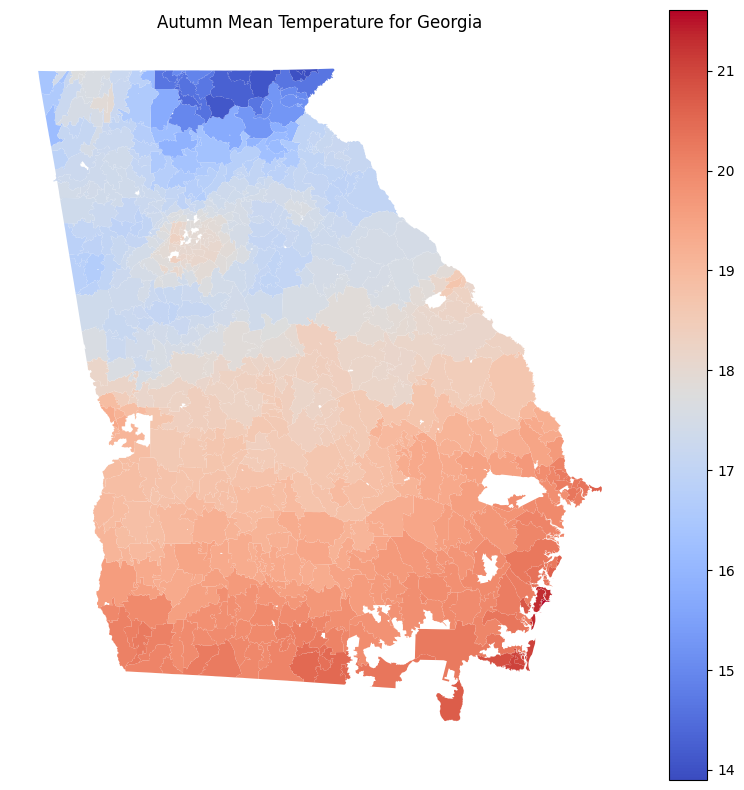

In [38]:

#Georgia Plots
gdf_GeorgiaDJF = plot_seasonal_temperature(raster_files=meanTemp_DJF,
                                       zip_intervals=georgia_intervals,
                                       shapefile_path=shapefile_path,
                                       title="Winter Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_GeorgiaMAM = plot_seasonal_temperature(raster_files=meanTemp_MAM,
                                       zip_intervals=georgia_intervals,
                                       shapefile_path=shapefile_path,
                                       title="Spring Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_GeorgiaJJA = plot_seasonal_temperature(raster_files=meanTemp_JJA,
                                       zip_intervals=georgia_intervals,
                                       shapefile_path=shapefile_path,
                                       title="Summer Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_GeorgiaSON = plot_seasonal_temperature(raster_files=meanTemp_SON,
                                       zip_intervals=georgia_intervals,
                                       shapefile_path=shapefile_path,
                                       title="Autumn Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)

Number of ZIP-code polygons after filtering: 1989


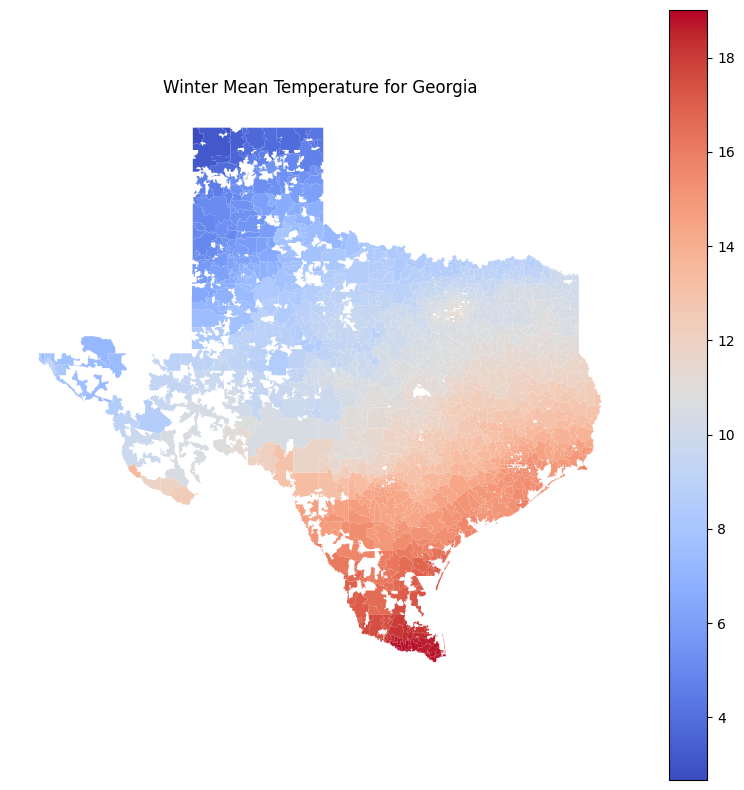

Number of ZIP-code polygons after filtering: 1989


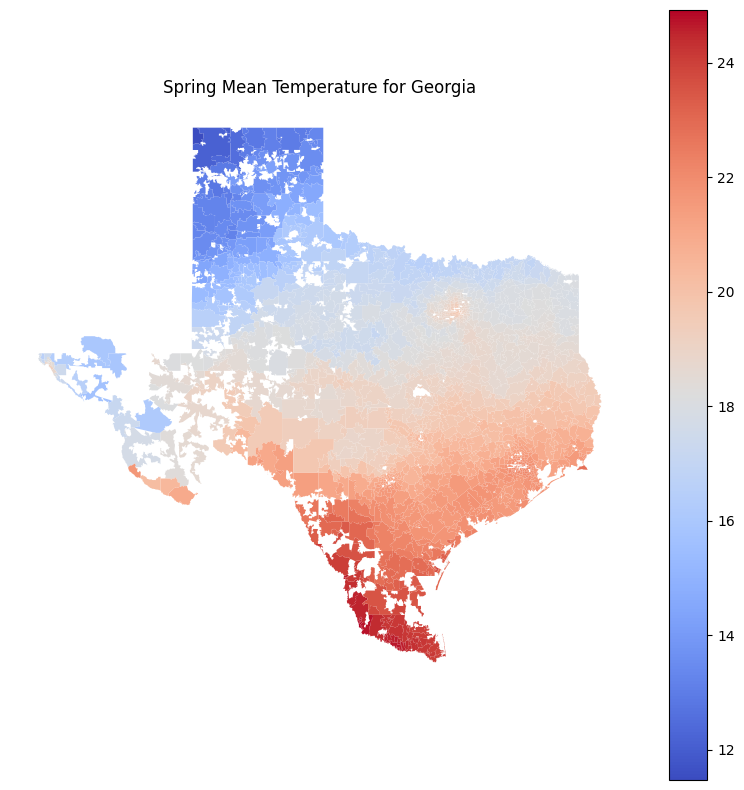

Number of ZIP-code polygons after filtering: 1989


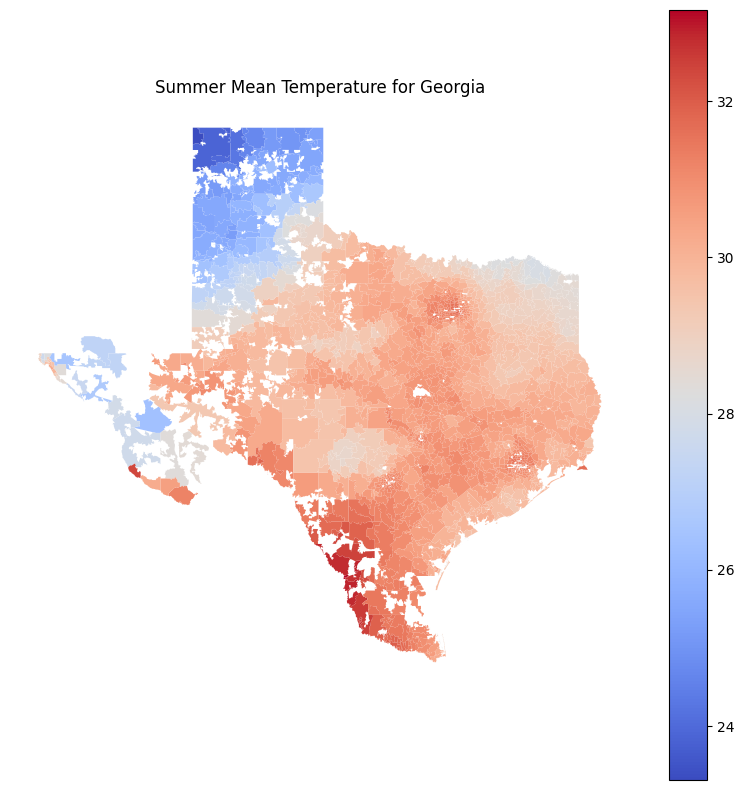

Number of ZIP-code polygons after filtering: 1989


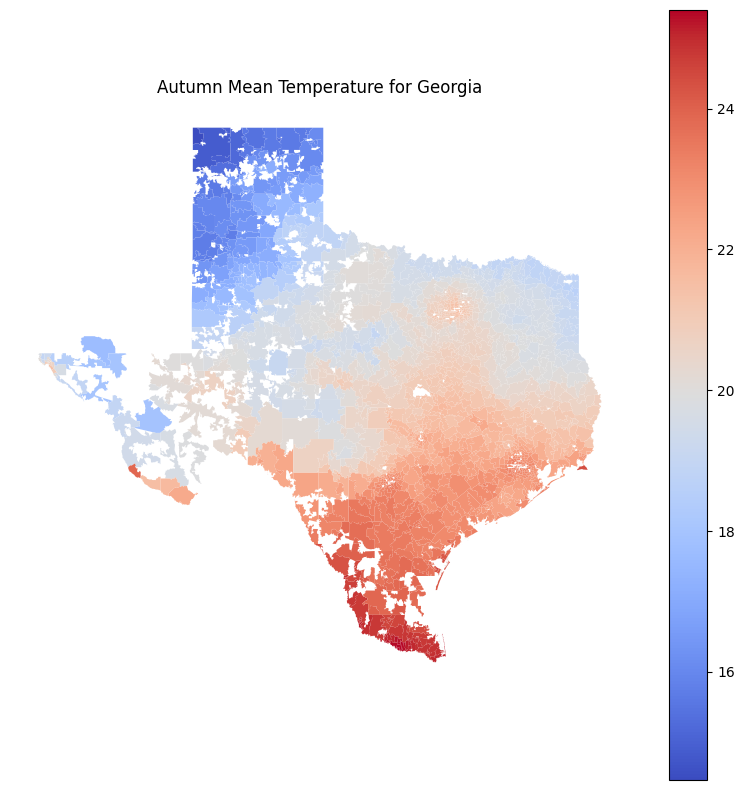

In [39]:

#Texas Plots
gdf_TexasDJF = plot_seasonal_temperature(raster_files=meanTemp_DJF,
                                       zip_intervals=texasIntervals,
                                       shapefile_path=shapefile_path,
                                       title="Winter Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_TexasMAM = plot_seasonal_temperature(raster_files=meanTemp_MAM,
                                       zip_intervals=texasIntervals,
                                       shapefile_path=shapefile_path,
                                       title="Spring Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_TexasJJA = plot_seasonal_temperature(raster_files=meanTemp_JJA,
                                       zip_intervals=texasIntervals,
                                       shapefile_path=shapefile_path,
                                       title="Summer Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)
gdf_TexasSON = plot_seasonal_temperature(raster_files=meanTemp_SON,
                                       zip_intervals=texasIntervals,
                                       shapefile_path=shapefile_path,
                                       title="Autumn Mean Temperature for Georgia",
                                       cmap="coolwarm",
                                       figsize=(10, 10),
                                       vmin=None, vmax=None)